# Demonstration and unit-testing `ri_ci` for Matlab

This file was tested on Matlab version 2019b, using the Jupyter `matlab_kernel`.

###  Matlab preliminaries

In [2]:
rng('default'); % set seed for replicability
addpath('../m'); % assumes we are in the /demo/ folder as pwd

In [2]:
%  Parameters of the simulation
N = 250; % number of observations
R = 400 ; % number of alternative permutations of the treatment assignment to be used
sigma_y0 = 2.5 ; % sd of outcome under control
tau = 1 ; % treatment effect

In [3]:
%  Generate data 
x = randn(N,1);
y0 = x + sigma_y0*randn(N,1);
y1 = y0 + tau;
t = (rand(N,1) >= 0.5 ) ; % treatment status
y = y0 + t.*(y1 - y0) ; % switching regression
T0 = (rand(N,R) >= 0.5) ; % set of potential randomizations
DATA = array2table([y,t,x] , 'VariableNames',{'y','t','x'});

##  Testing specific sharp nulls

###  Testing null that $\tau_0 = 0$


ans =

    '__RESULTS OF ANALYTICAL MODEL:__'


lm = 


Linear regression model:
    y ~ 1 + t

Estimated Coefficients:
                   Estimate      SE        tStat       pValue  
                   ________    _______    ________    _________

    (Intercept)    -0.13634    0.23155    -0.58882      0.55652
    t                1.0722    0.33146      3.2347    0.0013832


Number of observations: 250, Error degrees of freedom: 248
Root Mean Squared Error: 2.62
R-squared: 0.0405,  Adjusted R-Squared: 0.0366
F-statistic vs. constant model: 10.5, p-value = 0.00138

ans =

    'The p-value from Randomization Inference for the hypothesis that tau = 0.00 is 0.00'




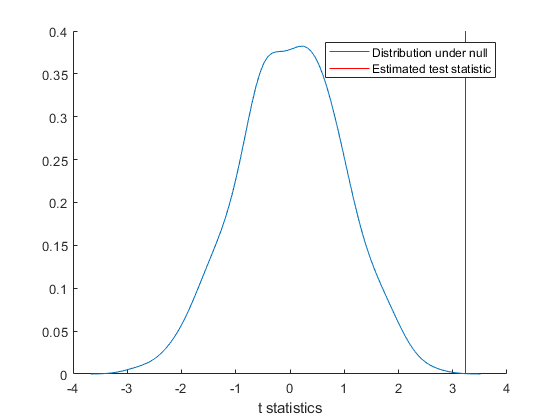

In [4]:
clear ri_ci
tau0 = 0;
[pval, ~, t1, t0] = ri_ci(DATA,{'y'},{'t'}, T0, R ,'tau0',0,'ShowMainEstimates',true);

figure(1)
clf
hax = axes;
hold on
ksdensity(t0) % distribution of test statistic under the null.
line([t1 t1],get(hax,'YLim'),'Color','red'); % 
xlabel('t statistics')
legend('Distribution under null','Estimated test statistic')
hold off

Illustrating one-sided versions of this hypothesis:

In [5]:
clear ri_ci
clear ri_estimates
leftprob = ri_ci(DATA,{'y'},{'t'}, T0, 100,'TestSide','left')
rightprob = ri_ci(DATA,{'y'},{'t'}, T0, 100,'TestSide','right')


leftprob =

     1


rightprob =

     0




###  Testing sharp nulls of non-zero treatment effects (e.g., $\tau_0=1$)

_Note:_  Model displays primary estimates that are the basis of analytic standard errors; p-values in that table correspond to test that $\tau_0=0$.


ans =

    'p-value associated with hypothesis tau0=1.00 is 0.865'




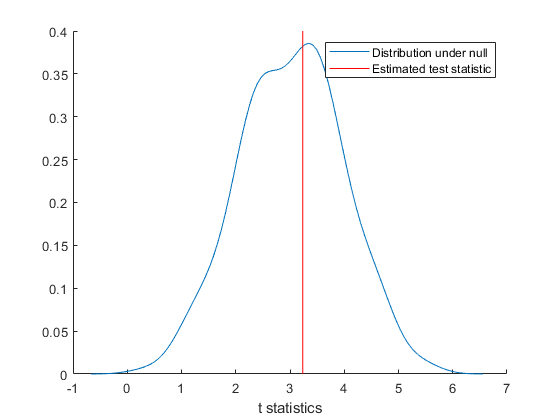

In [6]:
clear ri_ci
clear ri_estimates
tau0 = 1;
[pval, ~, t1, t0] = ri_ci(DATA,{'y'},{'t'}, T0, R,'tau0',tau0);

sprintf('p-value associated with hypothesis tau0=%2.2f is %0.3f',tau0,pval)

figure(2)
clf
hax = axes;
hold on
ksdensity(t0) % distribution of test statistic under the null.
line([t1 t1],get(hax,'YLim'),'Color','red'); % [0 1])
xlabel('t statistics')
legend('Distribution under null','Estimated test statistic')
hold off

## Finding 95% confidence interval

In [7]:
clear ri_ci
clear ri_estimates
tic
[pval,CI,~,~,Q_UB, Q_LB ] = ri_ci(DATA,{'y'},{'t'}, T0, R ,'FindCI',true);
toc

pval
CI 

Elapsed time is 98.541936 seconds.

pval =

     0


CI =

    0.4187    1.7637




In [8]:
[Q_UB, Q_LB]


ans =

    4.3205         0   -2.1762         0
    2.6964         0   -0.5520         0
    1.8843    0.0050    0.2601    0.0050
    1.4782    0.1900    0.6662    0.1950
    1.6813    0.0600    0.4631    0.0400
    1.7828    0.0150    0.3616    0.0150
    1.7320    0.0400    0.4124    0.0250
    1.7574    0.0300    0.4378    0.0350
    1.7701    0.0250    0.4251    0.0350
    1.7637    0.0300    0.4187    0.0300




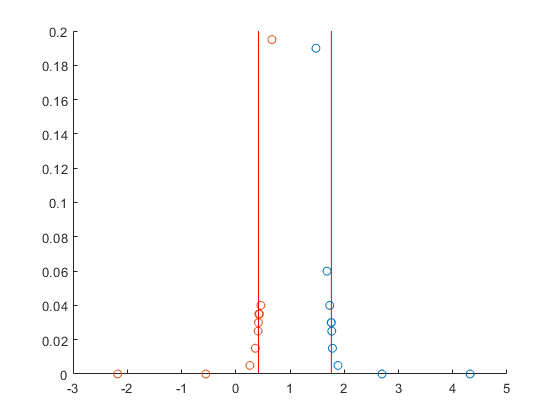

In [9]:
figure(3)
clf
hax = axes;
hold on
scatter(Q_UB(:,1),Q_UB(:,2))
scatter(Q_LB(:,1),Q_LB(:,2))
line([CI(1) CI(1)],get(hax,'YLim'),'Color','red'); % [0 1])
line([CI(2) CI(2)],get(hax,'YLim'),'Color','red'); % [0 1])
hold off

## Functionality with estimation commands other than `lm()`

When using estimation commands other than `lm()`, we will use 10 times the asymptotic confidence interval for OLS, assuming independent and homoskedastic errors, to define the search region, if the search region is not supplied by the user.

###  Use with `rereg()` for random effects.

To demonstrate how this can be used with `rereg()`, we will simluate data with cluster-randomized assignment.  Let there be groups $g=1,\ldots,G$, with $G=200$, and observations indexed by $\{ig\}$ with $n=5$ observations per group.

Let $y_{0,ig} = e_{0,g} + e_{0,ig}$ with each error term $\sim N(0,1)$.

Let the treatment effect, $\tau=1$, and $y_{1,ig}=y_{0,ig}+\tau$ for all $i,g$.

Observed outcomes are given by the _switching regression_ $y_{ig} = y_{0,ig} + (y_{1,ig} - y_{0,ig})  t_{ig} = y_{0,ig} + \tau t_{ig}$

In [10]:
const = 10 ; 
G=200;  % number of clusters
n=5;    % number of observations/cluster
t = (rand(G,1) >= 0.5 ) ; % treatment status
T0 = (rand(G,R) >= 0.5) ; % set of potential randomizations
x_g = randn(G,1) ; % observable at cluster level
e_0g = randn(G,1) ; % error term at cluster level
g = [1:G]';  % group index

%  Expand all group-level datasets to the individual level
t = kron(t,ones(n,1));
T0 = kron(T0,ones(n,1));
e_0g = kron(e_0g,ones(n,1));
x_g = kron(x_g,ones(n,1));
g = kron(g,ones(n,1));

%  constant additive treatment effect
tau = 1; 

%  remainder of DGP at individual level
e_0i = randn(G*n,1);
x_i = randn(G*n,1);
y0 = const + x_g + x_i + e_0g + e_0i ;
y1 = y0 + tau ;
y = y0 + tau * t;

%  Data to table, for passing to rereg.
D = array2table([y,t,x_i,x_g,g],'VariableNames',{'y' 't' 'x_i' 'x_g' 'g'});

**Demonstrating use of `rereg()`**.  Note that this estimator, as programmed, uses cluster-robust standard errors and makes a degrees-of-freedom correction to the variance-covariance matrix, as discussed in Greene (eq. 11.3).

In [11]:
clear rereg
lm = fitlm(D,'y~ t + x_i + x_g') % ([t x_g x_i ],y)
%beta_re = rereg(y,[t , x_g, x_i],g)  % <- ols syntax:  assumes data are in arrays rather than tables.
re = rereg(D,{'y'},{'t' 'x_i' 'x_g'},{'g'})


lm = 


Linear regression model:
    y ~ 1 + t + x_i + x_g

Estimated Coefficients:
                   Estimate      SE       tStat       pValue  
                   ________    _______    ______    __________

    (Intercept)     10.019     0.06701    149.51             0
    t              0.94132     0.09067    10.382    4.7992e-24
    x_i            0.96252       0.045    21.389    8.0056e-84
    x_g             1.0072     0.04335    23.235    9.1037e-96


Number of observations: 1000, Error degrees of freedom: 996
Root Mean Squared Error: 1.42
R-squared: 0.52,  Adjusted R-Squared: 0.519
F-statistic vs. constant model: 360, p-value = 2.59e-158

re =

  4x3 table

                 beta         SE       tStat 
                _______    ________    ______

    Constant     10.019     0.12107    82.753
    t           0.94075     0.15549    6.0504
    x_i         0.98184    0.034375    28.563
    x_g           1.007    0.074606    13.498




**Demonstrate use of `ri_ci()` to obtain p-values for test of zero null with random effects estimation via `rereg`**

In [12]:
clear rereg
clear ri_ci
tic
pval = ri_ci(D,{'y'},{'t'}, T0, R,'Model','re','GroupVar',{'g'} )
toc


ans =

    'Now estimating RE model'


result =

  2x3 table

                 beta       SE       tStat 
                ______    _______    ______

    Constant    10.094    0.16961    59.515
    t           0.7646    0.22411    3.4116


pval =

     0

Elapsed time is 11.621130 seconds.



**Demonstrate use of `ri_ci()` to obtain confidence intervals with random effects estimation via `rereg`.**

In [13]:
clear ri_ci
clear ri_estimates
tic
[pval,CI,~,~,Q_UB, Q_LB ] = ri_ci(D,{'y'},{'t'}, T0, R ...
    , 'Model', 're', 'GroupVar',{'g'} ...
    ,'FindCI',true ...
    , 'TestZero', false ... % don't bother with p-value for tau=0
    );
toc


ans =

    'Now estimating RE model'


result =

  2x3 table

                 beta       SE       tStat 
                ______    _______    ______

    Constant    10.094    0.16961    59.515
    t           0.7646    0.22411    3.4116

Elapsed time is 287.501063 seconds.




pval =

     []


CI =

    0.2842    1.3265




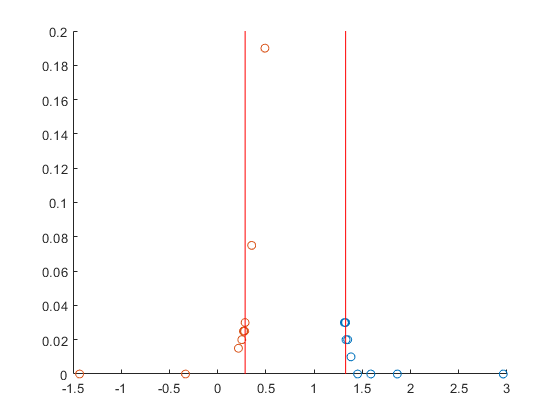

In [14]:
pval
CI
% [Q_UB, Q_LB]
figure(4)
clf
hax = axes;
hold on
scatter(Q_UB(:,1),Q_UB(:,2))
scatter(Q_LB(:,1),Q_LB(:,2))
line([CI(1) CI(1)],get(hax,'YLim'),'Color','red'); % [0 1])
line([CI(2) CI(2)],get(hax,'YLim'),'Color','red'); % [0 1])
hold off

### Use with `kstest()` for Kolmogorov-Smirnov test statistic

Getting a $p$-value only.

In [15]:
clear ri_ci
tic
[pval ] = ri_ci(D,{'y'},{'t'}, T0, R ...
    , 'Model', 'ks' ...
    , 'TestZero', true ... 
    , 'FindCI', false ...
    );
toc



TEST1 =

    0.1875

Elapsed time is 0.128419 seconds.



Finding the 95 percent confidence interval

In [16]:

clear ri_ci
tic
[pval ,CI,~,~,Q_UB,Q_LB] = ri_ci(D,{'y'},{'t'}, T0, R ...
    , 'Model', 'ks' ...
    , 'TestZero', true ... 
    , 'FindCI', true ...
    ); 
toc


TEST1 =

    0.1875

Elapsed time is 2.171009 seconds.



Illustrating the search process for the 95 percent confidence interval.


ans =

    2.0178         0   -0.4886         0
    1.3912    0.0450    0.1380    0.0050
    1.7045    0.0050    0.4513    0.2250
    1.5478    0.0200    0.2946    0.0400
    1.4695    0.0300    0.2163    0.0200
    1.5087    0.0250    0.2555    0.0350
    1.4891    0.0250    0.2359    0.0300
    1.4793    0.0250    0.2261    0.0300
    1.4744    0.0300    0.2212    0.0150
    1.4769    0.0300    0.2237    0.0150




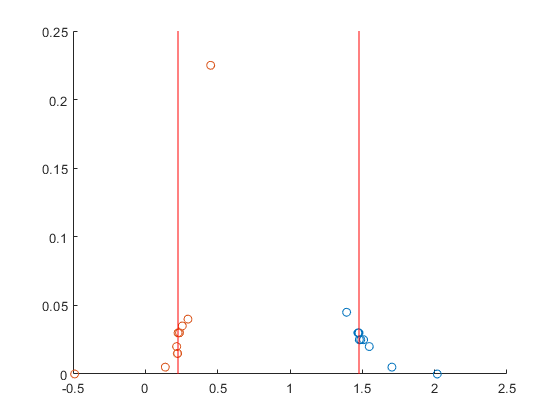

In [17]:
[Q_UB, Q_LB]

figure(5)
clf
hax = axes;
hold on
scatter(Q_UB(:,1),Q_UB(:,2))
scatter(Q_LB(:,1),Q_LB(:,2))
line([CI(1) CI(1)],get(hax,'YLim'),'Color','red'); % [0 1])
line([CI(2) CI(2)],get(hax,'YLim'),'Color','red'); % [0 1])
hold off

##  Functionality in a model with covariates

In [31]:
%  DGP
N = 200;
x = randn(N,1);
e0 = 10*randn(N,1); 
tau = 1 ; 
y0 = x + e0;
y1 = y0 + tau;
t = (rand(N,1) > 0.5);
y = y0 + t*tau;
DATA = array2table([y,t,x],'VariableNames',{'y' 't' 'x'});

%  Feasible randomizations
T0 = (rand(N,1000) > 0.5);
size(T0)


ans =

         200        1000




In [40]:
%  p-values with and without covariates
clear ri_ci 
pval1 = ri_ci(DATA,{'y'},{'t'},T0,300,'Model','lm')
pval2 = ri_ci(DATA,{'y'},{'t'},T0,300,'Controls',{'x'},'Model','lm')


pval1 =

    0.0200


pval2 =

    0.0133




In [41]:
%  CI with and without covariates
clear ri_ci 
[pval1, ci1] = ri_ci(DATA,{'y'},{'t'},T0,300,'Model','lm','FindCI',true)
[pval2, ci2] = ri_ci(DATA,{'y'},{'t'},T0,300,'Controls',{'x'},'Model','lm','FindCI',true)


pval1 =

    0.0200


ci1 =

    0.0201    6.7789


pval2 =

    0.0133


ci2 =

    0.1412    6.9188




####  Case of categorical covariates

In [5]:
%  DGP
N = 200;
D = ceil(5*rand(N,1));
e0 = 10*randn(N,1); 
tau = 1 ; 
y0 = D + e0; % of course no reason for the effects of categorical variable to be cardinal like this...
y1 = y0 + tau;
t = (rand(N,1) > 0.5);
y = y0 + t*tau;
DATA = array2table([y,t],'VariableNames',{'y' 't' });
D = categorical(D); 
DATA.D = D; 
%  Feasible randomizations
T0 = (rand(N,1000) > 0.5);
size(T0)


ans =

         200        1000




In [12]:
%  p-values with and without covariates
clear ri_ci 
pval1 = ri_ci(DATA,{'y'},{'t'},T0,300,'Model','lm')
pval2 = ri_ci(DATA,{'y'},{'t'},T0,300,'Controls',{'D'},'Model','lm')


lm = 


Linear regression model:
    y ~ 1 + t

Estimated Coefficients:
                   Estimate      SE        tStat      pValue 
                   ________    _______    _______    ________

    (Intercept)     1.7763     0.92822     1.9137    0.057101
    t               1.0453      1.2631    0.82757     0.40891


Number of observations: 200, Error degrees of freedom: 198
Root Mean Squared Error: 8.9
R-squared: 0.00345,  Adjusted R-Squared: -0.00159
F-statistic vs. constant model: 0.685, p-value = 0.409

TEST1 =

    0.8276


pval1 =

    0.3533


ans =

    'Checking controls for categorical variables'


lm = 


Linear regression model:
    y ~ 1 + t + D_2 + D_3 + D_4 + D_5

Estimated Coefficients:
                   Estimate      SE       tStat      pValue 
                   ________    ______    ________    _______

    (Intercept)      1.2844    1.5043     0.85384    0.39425
    t               0.93094    1.2754      0.7299    0.46633
    D_2            -0.27929     2.043 

### CIs with categorical covariates

In [14]:
clear ri_ci 
[pval1, ci1] = ri_ci(DATA,{'y'},{'t'},T0,300,'Model','lm','FindCI',true)
[pval2, ci2] = ri_ci(DATA,{'y'},{'t'},T0,300,'Controls',{'D'},'Model','lm','FindCI',true)


lm = 


Linear regression model:
    y ~ 1 + t

Estimated Coefficients:
                   Estimate      SE        tStat      pValue 
                   ________    _______    _______    ________

    (Intercept)     1.7763     0.92822     1.9137    0.057101
    t               1.0453      1.2631    0.82757     0.40891


Number of observations: 200, Error degrees of freedom: 198
Root Mean Squared Error: 8.9
R-squared: 0.00345,  Adjusted R-Squared: -0.00159
F-statistic vs. constant model: 0.685, p-value = 0.409

TEST1 =

    0.8276


pval1 =

    0.3533


ci1 =

   -1.8559    3.6565


ans =

    'Checking controls for categorical variables'


lm = 


Linear regression model:
    y ~ 1 + t + D_2 + D_3 + D_4 + D_5

Estimated Coefficients:
                   Estimate      SE       tStat      pValue 
                   ________    ______    ________    _______

    (Intercept)      1.2844    1.5043     0.85384    0.39425
    t               0.93094    1.2754      0.7299    0.46633
    D_2 

###  CIs with categorical covariates and nuisance treatments

Using the `plug-in' estimate. 

In [21]:
%  DGP
N = 200;
D = ceil(5*rand(N,1));
e0 = 10*randn(N,1); 
tau = [1,1]' ; 
y0 = D + e0; % of course no reason for the effects of categorical variable to be cardinal like this...
t = (rand(N,2) > 0.5);
y = y0 + t*tau;
DATA = array2table([y,t],'VariableNames',{'y' 't1' 't2' });
D = categorical(D); 
DATA.D = D; 
%  Feasible randomizations
T0 = (rand(N,1000,2) > 0.5);
size(T0)


ans =

         200        1000           2




In [24]:
%  P-value
clear ri_ci 
[pval1] = ri_ci(DATA,{'y'},{'t1','t2'},T0,200,'Model','lm','TheTx','t1')
[pval2] = ri_ci(DATA,{'y'},{'t1','t2'},T0,200,'Controls',{'D'},'Model','lm')


lm = 


Linear regression model:
    y ~ 1 + t1 + t2

Estimated Coefficients:
                   Estimate      SE        tStat      pValue 
                   ________    ______    _________    _______

    (Intercept)      2.0425    1.3715       1.4892    0.13804
    t1             -0.10037    1.5748    -0.063736    0.94924
    t2               2.4382    1.5755       1.5476    0.12333


Number of observations: 200, Error degrees of freedom: 197
Root Mean Squared Error: 11.1
R-squared: 0.0121,  Adjusted R-Squared: 0.0021
F-statistic vs. constant model: 1.21, p-value = 0.3

TEST1 =

   -0.0637


b_nuisance =

    2.4382


pval1 =

    0.8600


ans =

    'Checking controls for categorical variables'


lm = 


Linear regression model:
    y ~ 1 + t1 + t2 + D_2 + D_3 + D_4 + D_5

Estimated Coefficients:
                   Estimate      SE       tStat     pValue 
                   ________    ______    _______    _______

    (Intercept)    0.27472     2.0827     0.1319     0.8952
    t1

In [26]:
%  CIs
[pval1,ci1] = ri_ci(DATA,{'y'},{'t1','t2'},T0,200,'Model','lm','TheTx','t1','FindCI',true)
[pval2,ci2] = ri_ci(DATA,{'y'},{'t1','t2'},T0,200,'Controls',{'D'},'Model','lm','FindCI',true)


lm = 


Linear regression model:
    y ~ 1 + t1 + t2

Estimated Coefficients:
                   Estimate      SE        tStat      pValue 
                   ________    ______    _________    _______

    (Intercept)      2.0425    1.3715       1.4892    0.13804
    t1             -0.10037    1.5748    -0.063736    0.94924
    t2               2.4382    1.5755       1.5476    0.12333


Number of observations: 200, Error degrees of freedom: 197
Root Mean Squared Error: 11.1
R-squared: 0.0121,  Adjusted R-Squared: 0.0021
F-statistic vs. constant model: 1.21, p-value = 0.3

TEST1 =

   -0.0637


b_nuisance =

    2.4382


pval1 =

    0.8600


ci1 =

   -3.9587    3.7580


ans =

    'Checking controls for categorical variables'


lm = 


Linear regression model:
    y ~ 1 + t1 + t2 + D_2 + D_3 + D_4 + D_5

Estimated Coefficients:
                   Estimate      SE       tStat     pValue 
                   ________    ______    _______    _______

    (Intercept)    0.27472     2.082